# Proteomic Data Aggregation and Visualization


This notebook demonstrates aggregation of proteomic data via the National Microbiome Data Collaborative (NMDC)'s [Runtime API](https://api.microbiomedata.org/docs). It uses the `nmdc_api_utilities` package (as of March 2025) to do this exploration. It involves using `nmdc_api_utilites` objects to make NMDC API requests easier, and using utility function to help us with data processing tasks. More information about the package can be found [here](https://microbiomedata.github.io/nmdc_api_utilities/). It highlights how the NMDC's schema can be used to overcome some of the numerous challenges associated with this type of aggregation. Please note that this notebook is intended for individuals with experience performing mass spectrometry based proteomic analyses and that various parameter and processing choices were made for this example use case. They are not broadly applicable and should be adjusted as needed. 

Notebook Steps:

1) Assess background information and collect datasets for an example study of riverbed sediment along the Columbia River

2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

3) Collapse to unique peptides and normalize quantification

4) Extract functional gene annotations for proteins

5) Generate annotation and protein mappings for peptides using "Razor" strategy

6) Perform protein rollup using the "Razor" results and summarize into an aggregated table of relative protein abundance




## Define a function to split a list into chunks 

Since we will need to use a list of ids to query a new collection in the API, we need to limit the number of ids we put in a query. This function splits a list into chunks of 100. Note that the `chunk_size` has a default of 100, but can be adjusted.

In [9]:
# Define a function to split ids into chunks
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

## Define a function to get a list of ids from initial results
In order to use the identifiers retrieved from an initial API request in another API request, this function is defined to take the initial request results and use the `id_name` key from the results to create a list of all the ids. The input is the initial result list and the name of the id field.

In [10]:
def get_id_list(result_list: list, id_name: str):
    id_list = []
    for item in result_list:
        if type(item[id_name]) == str:
            id_list.append(item[id_name])
        elif type(item[id_name]) == list:
            for another_item in item[id_name]:
                id_list.append(another_item)

    return id_list

Import libraries and python scripts containing functions necessary to run this notebook. 'aggregation_functions.py' (also in this folder) includes spectral probability filtering and protein mapping functions. `nmdc_api_utilities` includes functions for API traversal of the collections endpoint.

In [ ]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from IPython.display import Image, display
import nmdc_api_utilities

if 'google.colab' in sys.modules:

   #module in this folder with specific protein aggregation functions
   !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/proteomic_aggregation/python/aggregation_functions.py
   import aggregation_functions as agg_func

   #pmartR logo
   !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/proteomic_aggregation/pmartR_logo_final.jpg

else:
  #module in this folder with specific protein aggregation functions
  import aggregation_functions as agg_func

  #module for API functions currently residing in NOM_visualizations
  api_func=agg_func.import_relative_module("nmdc_api", "../../NOM_visualizations/python/nmdc_api.py")

## 1) Assess background information and collect data for an example study of riverbed sediment along the Columbia River

Review the example study on the [NMDC data portal](https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51). Use the study `id` embedded in the url (nmdc:sty-11-aygzgv51) to collect all related data objects via `nmdc_api_utilities` package and reformat the json output into a pandas dataframe. These data objects reference both input files (i.e. raw, gff) and output files (i.e. metaproteomic results) to the NMDC workflows. To get the data_objects, we will create a DataObjectSearch object and use the get_data_objects_for_studies() function.

In [5]:
from nmdc_api_utilities.data_object_search import DataObjectSearch
do_client = DataObjectSearch()
#get all data objects associated with this study id using the NMDC find endpoint
data = do_client.get_data_objects_for_studies(study_id='nmdc:sty-11-aygzgv51')
data = pd.DataFrame(data)

#reformat data into dataframe (keeping biosample id)
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = row.explode('data_objects').drop_duplicates()
    row_out = pd.json_normalize(row_out)
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects)[['id','name','file_size_bytes','data_object_type','md5_checksum','url','biosample_id','in_manifest']]
display(data_objects)

del data, index, row, row_out, bio_id



,id,name,file_size_bytes,data_object_type,md5_checksum,url,biosample_id,in_manifest
0,NaN,NaN,NaN,NaN,NaN,NaN,nmdc:bsm-13-amrnys72,NaN
1,nmdc:dobj-13-f605mj12,9289.1.128215.TCCTGAG-TATCCTC.fastq.gz,6.700068e+09,Metagenome Raw Reads,NaN,NaN,nmdc:bsm-13-amrnys72,NaN
2,nmdc:dobj-13-20vg7p81,nmdc_wfmgas-13-01678h03.1_contigs.fna,2.507473e+08,Assembly Contigs,3d9e14d6f7a854042a7d71def080409b,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-amrnys72,NaN
...,...,...,...,...,...,...,...,...
8,nmdc:dobj-13-a1288f79,Unground_SBR_Spring_2014_FC_S3_50-60_H2Oext_22...,1.399500e+04,FT ICR-MS Analysis Results,32d61ae97aae206e3a0a659ac26c9207,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:bsm-13-7sbt2x61,NaN
9,nmdc:dobj-13-h2j6dr08,output: Unground_SBR_Spring_2014_FC_S3_50-60_M...,3.052338e+07,NaN,NaN,NaN,nmdc:bsm-13-7sbt2x61,NaN
10,nmdc:dobj-13-p84dp061,Unground_SBR_Spring_2014_FC_S3_50-60_MeOHExt_2...,8.462700e+04,FT ICR-MS Analysis Results,719a8a2b088256e51518f63641ea197e,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:bsm-13-7sbt2x61,NaN


Subset the data objects to 'Unfiltered Metaproteomic Results'. These files contain the proteomic workflow outputs that will be used for proteomic aggregation.

In [7]:
proteomic_output_df = data_objects[data_objects['data_object_type']=='Unfiltered Metaproteomics Results'].reset_index(drop=True).rename(columns={'id':'processed_DO_id'})
display(proteomic_output_df)

,processed_DO_id,name,file_size_bytes,data_object_type,md5_checksum,url,biosample_id,in_manifest
0,nmdc:dobj-11-wcn69x37,nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_ms...,7698320.0,Unfiltered Metaproteomics Results,bdc3191137d45d54afabca583205a872,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-kcdh3w94,[nmdc:manif-11-7796sg87]
1,nmdc:dobj-11-bxyvx506,nmdc_dobj-11-xvmb4058_nmdc_dobj-11-bvya7a43_ms...,10580159.0,Unfiltered Metaproteomics Results,205bc0ca0620058a156011681d07832d,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-1p0tct86,[nmdc:manif-11-7796sg87]
2,nmdc:dobj-11-z8hc0j30,nmdc_dobj-11-hp2vmj63_nmdc_dobj-11-716e7y35_ms...,8376109.0,Unfiltered Metaproteomics Results,8785b9538d977a50fd35d11bfcb037ce,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-2fw5j754,[nmdc:manif-11-7796sg87]
...,...,...,...,...,...,...,...,...
30,nmdc:dobj-11-7psagy79,nmdc_dobj-11-erc74h90_nmdc_dobj-11-sekqwq68_ms...,10282205.0,Unfiltered Metaproteomics Results,7f35ff00b17f0d4e2bd5e62181005f43,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-3pvn5d70,[nmdc:manif-11-7796sg87]
31,nmdc:dobj-11-tk9hc081,nmdc_dobj-11-e2309414_nmdc_dobj-11-0f1b2t61_ms...,8161710.0,Unfiltered Metaproteomics Results,4c9d199ca4c13e095a3d5caec558da9b,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-amdcp906,[nmdc:manif-11-7796sg87]
32,nmdc:dobj-11-2szyc560,nmdc_dobj-11-tezmee57_nmdc_dobj-11-w2c1ee09_ms...,8117239.0,Unfiltered Metaproteomics Results,fd8a212ad33a8162857d0ca164760333,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,nmdc:bsm-13-vqk1y255,[nmdc:manif-11-7796sg87]


There are various requirements that enable mass spectrometry runs to be aggregated and analyzed together. For example, runs need to be performed in succession, on the same instrument. The NMDC schema can make it easier to find these proteomic results by linking them via a slot called `in_manifest`.

Look at the `in_manifest` id on these proteomic outputs to confirm that all runs are in the same manifest record, and pull that record. If that manifest record's `manifest_category` value is 'instrument_run', then it confirms that these are LC-MS/MS runs that were performed in succession on the same instrument. Proteomic outputs from different manifest records should not be aggregated.

Using the nmdc_api_utilities package, we create a ManifestSearch object, create the needed filter, and use the get_record_by_filter() function to get records. 

In [12]:
from nmdc_api_utilities.manifest_search import ManifestSearch
from nmdc_api_utilities.data_processing import DataProcessing
#extract in_manifest ids for this study (in this case a single one available)
manifest_id = proteomic_output_df.explode('in_manifest')['in_manifest'].unique()
# create an instance of the data processing object
dp_client = DataProcessing()
# since we are querying the manifest collection, we need to create an instance of it
m_client = ManifestSearch()
# use utility function to get a list of the ids from processed_nom
result_ids = get_id_list(proteomic_output_df.to_dict(orient='records'), "in_manifest")
# create a list of lists of ids to query the ManifestSearch object
chunked_list = split_list(result_ids)
manifest = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the ManifestSearch object looking for recordds where the id field is in the chunk of ids from proteomic_output_df
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    manifest += m_client.get_record_by_filter(filter=filter, max_page_size=100, all_pages=True)

display(manifest)

[{'id': 'nmdc:manif-11-7796sg87',
  'manifest_category': 'instrument_run',
  'type': 'nmdc:Manifest',
  'description': 'collection of metaproteomic analyses from the same instrument run nmdc:sty-11-aygzgv51'}]

Look at an example of the information in 'Unfiltered Metaproteomics Results', which contains peptide identification and relative abundance information.

In [13]:
#example unfiltered results 
unfilt_results = proteomic_output_df.iloc[0]["url"]
print(unfilt_results)
display(agg_func.tsv_extract(unfilt_results))

del unfilt_results

https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_msgfplus_syn_PlusSICStats.txt


,ResultID,Scan,FragMethod,SpecIndex,Charge,PrecursorMZ,DelM,DelM_PPM,MH,Peptide,...,PeakMaxIntensity,PeakSignalToNoiseRatio,FWHMInScans,PeakArea,ParentIonIntensity,ParentIonMZ,StatMomentsArea,PeakScanStart,PeakScanEnd,PeakWidthMinutes
0,1,36395,HCD,1,2,1098.00403,0.00318,1.44939,2193.994250,K.SAYPGQITSNMFCAGYLEGGK.D,...,242049.0,85.520,268,1.641300e+07,85675.0,1098.00,8.999200e+06,36001,36752,0
1,2,23937,HCD,2,3,721.68903,-0.00384,-1.77602,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,223900000.0,903.800,81,1.989200e+10,2994700.0,721.69,1.823700e+10,23819,24330,0
2,3,45758,HCD,3,2,1082.52820,-0.01067,-4.93472,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,1841600.0,5.298,334,5.948800e+08,1279900.0,1082.53,4.077900e+08,45649,46197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31923,31924,6605,HCD,26743,2,590.77094,-0.01103,-9.35603,1179.542201,R.MLDGDTERSR.H,...,172138.0,10.310,115,8.929200e+06,134262.0,590.77,3.611600e+06,6472,6623,0
31924,31925,25719,HCD,26744,2,1173.53979,-0.03561,-15.18653,2346.107833,-.KIEMHFLPDVYVPCETCHGK.R,...,239975.0,58.450,6,4.310700e+06,1304.7,1173.54,1.346400e+06,25637,25838,0
31925,31926,12373,HCD,26745,2,753.36945,0.01674,11.11853,1506.718237,R.EELDDPVRSQYR.E,...,484543.0,4.170,83,4.875100e+07,530695.0,753.37,1.752300e+07,12240,12401,0


Extract information from all 33 proteomic results via the function iterate_file_extract() in agg_func, and put them into a single dataframe, where each scan in each dataset has the unique identifier `SpecID`. Clean prefix and suffix off of each peptide sequence. Since this data was processed using a target-decoy approach, determine the type of protein being matched to each peptide: contaminant, reverse (false positive match to the reversed amino acid sequence of a protein), or forward (match to the true, forward amino acid sequence of a protein). The presence of forward and reverse matches enables FDR estimation in the next step.

In [14]:
unfilt_res = agg_func.iterate_file_extract(identifier_col='processed_DO_id',
                                url_col='url',
                                extract_cols=['Charge','Scan','Peptide','Protein','MSGFDB_SpecEValue','StatMomentsArea'],
                                pd_df=proteomic_output_df,
                                filter_col = None,
                                filter_values = None,
                                file_type='tsv'
                                )


#create identifier for each scan in each dataset
unfilt_res["SpecID"] = unfilt_res.apply(lambda row: str(row["id_col"]) + "_" + str(row["Scan"]), axis=1)

#clean off the prefix and suffix from the sequence but keep any mods
unfilt_res["Peptide Sequence with Mods"] = unfilt_res["Peptide"].apply(agg_func.sequence_noprefsuff)
del unfilt_res['Peptide']

#determine protein type (contaminant, reverse, forward)
unfilt_res["Protein_Type"] = unfilt_res["Protein"].apply(agg_func.findproteinname)

unfilt_res

,Charge,Scan,Protein,MSGFDB_SpecEValue,StatMomentsArea,id_col,SpecID,Peptide Sequence with Mods,Protein_Type
0,2,36395,Contaminant_TRYP_BOVIN,1.754200e-23,8.999200e+06,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_36395,SAYPGQITSNMFCAGYLEGGK,None
1,3,23937,Contaminant_TRYP_BOVIN,1.322500e-22,1.823700e+10,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_23937,LGEDNINVVEGNEQFISASK,None
2,2,45758,Contaminant_TRYP_BOVIN,2.022700e-22,4.077900e+08,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_45758,LGEDNINVVEGNEQFISASK,None
...,...,...,...,...,...,...,...,...,...
1040341,3,31259,XXX_nmdc:wfmgan-11-z0raab34.1_062580_2_376,4.998500e-07,2.905500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_31259,MNAAEANSHADPDHMGAISVATRLGELPHANK,Reversed
1040342,2,10035,nmdc:wfmgan-11-z0raab34.1_157112_40_279,4.998700e-07,5.271900e+09,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_10035,APDLMIFAK,Forward
1040343,3,4075,XXX_nmdc:wfmgan-11-z0raab34.1_020416_230_607,4.999200e-07,9.764500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_4075,EAESEEFRQRAK,Reversed


## 2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

A challenge associated with aggregating mass spectrometry data is that there are always false identifications, which can be mitigated by imposing a spectral probability filter on the data being analyzed. The same spectral probability filter needs to be applied across datasets when they are being compared. The filter value itself is chosen by weighing the number of 'true' identifications retained with the proximity of the data to a chosen false discovery rate (FDR) (usually 0.05 or 0.01). NMDC's metaproteomic workflow provides 'true' and 'false' identifications for FDR estimation in the 'Unfiltered Metaproteomic Result' files.

Create a dataframe of peptide identifications (ignoring protein mapping). Filter identifications to the peptide sequence with the smallest SpecEValue for each SpecID, so there is a single, highest probability identification for each scan.

In [15]:
edata = unfilt_res[['SpecID','Peptide Sequence with Mods','MSGFDB_SpecEValue','Protein_Type','StatMomentsArea']].drop_duplicates()  # important to remove any duplicated rows here!

#for each SpecID, select the peptide spectrum match with the smallest MSGFDB_SpecEValue (.idxmin() takes the first entry when there's multiple matches)
idx = edata.groupby(['SpecID'])['MSGFDB_SpecEValue'].idxmin()
edata = edata.loc[idx].reset_index(drop=True)
del idx

display(edata)

assert len(edata['SpecID'].unique())==edata.shape[0], "still more than one identification per scan"

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,Protein_Type,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,Forward,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,Forward,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,Forward,5.731600e+07
...,...,...,...,...,...
874556,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,Reversed,6.141800e+06
874557,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,Reversed,4.143000e+07
874558,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,Forward,2.284500e+06


Create separate dataframes of forward and reverse peptide spectrum matches.

In [16]:
forward_peptides = edata[edata["Protein_Type"] == "Forward"].copy().reset_index(drop=True)
del forward_peptides["Protein_Type"]
display(forward_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,5.731600e+07
...,...,...,...,...
441013,nmdc:dobj-11-zn9eyg46_9959,DAVSGRHHAQGR,6.589700e-09,1.566600e+07
441014,nmdc:dobj-11-zn9eyg46_9967,FYRFSGR,1.080500e-07,3.418000e+08
441015,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,2.284500e+06


In [17]:
reversed_peptides = edata[edata["Protein_Type"] == "Reversed"].copy().reset_index(drop=True)
del reversed_peptides["Protein_Type"]
del edata
display(reversed_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.021500e-07,7.371400e+08
1,nmdc:dobj-11-2k6s1505_10019,QWHPNFLR,3.448500e-07,3.220300e+09
2,nmdc:dobj-11-2k6s1505_10026,LAEREGGAR,1.451200e-08,9.604800e+08
...,...,...,...,...
420110,nmdc:dobj-11-zn9eyg46_9969,TDTATHWHK,1.879300e-07,1.960000e+08
420111,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,6.141800e+06
420112,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,4.143000e+07


Use the function optimize_specFilt() in agg_func to find a log10 spectral probability filter that weighs the number of forward peptides retained with the proximity of the dataset to a 0.05 spectral FDR. Visualize the impact of the spectral probability filter by plotting the number of forward and reverse peptides retained. 

The main plot below is a histogram of forward and reverse peptides across all spectral probability values. The inset within this plot depicts a subset of the smallest spectral probabililty values, with the red bar before the dashed line representing the estimated number of false identifications that will be included in this analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

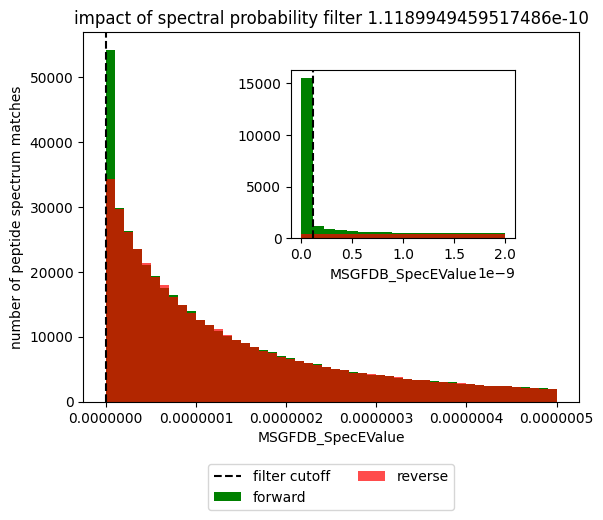

In [18]:
#initial guess at a log10 spectral probability filter value
initial_specprob_filter = -15

#perform optimization
optimization = agg_func.optimize_specFilt(initial_specprob_filter,forward_peptides,reversed_peptides)

#visualize filter
fitted_params=optimization.x
fig, ax_main = plt.subplots()
ax_inset = plt.axes([0.45, 0.45, 0.35, 0.35])


# Main plot
# forward peptides
hist, bins = np.histogram(forward_peptides["MSGFDB_SpecEValue"], bins=50)
ax_main.bar(bins[:-1], hist, width=np.diff(bins), align='edge', color='g', label='forward')

# reverse peptides
hist, bins = np.histogram(reversed_peptides["MSGFDB_SpecEValue"], bins=50)
ax_main.bar(bins[:-1], hist, width=np.diff(bins), align='edge',color='r', alpha=0.7, label='reverse')

# filter cutoff
ax_main.axvline(x=10 ** fitted_params[0], color="black", label = 'filter cutoff', linestyle="--")
ax_main.set_ylabel('number of peptide spectrum matches')
ax_main.set_xlabel('MSGFDB_SpecEValue')
ax_main.ticklabel_format(style='plain', axis='x')
ax_main.set_title(f'impact of spectral probability filter {10 ** fitted_params[0]}')
ax_main.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)


# Inset plot
# forward peptides
hist, bins = np.histogram(forward_peptides[forward_peptides["MSGFDB_SpecEValue"] < 0.000000002]["MSGFDB_SpecEValue"], bins=18)
ax_inset.bar(bins[:-1], hist, width=np.diff(bins), align='edge', color='g')

# reverse peptides
hist, bins = np.histogram(reversed_peptides[reversed_peptides["MSGFDB_SpecEValue"] < 0.000000002]["MSGFDB_SpecEValue"], bins=18)
ax_inset.bar(bins[:-1], hist, width=np.diff(bins), align='edge',color='r', alpha=0.7)

# filter cutoff
ax_inset.axvline(x=10 ** fitted_params[0], color="black", label = 'filter cutoff', linestyle="--")
ax_inset.set_xlabel('MSGFDB_SpecEValue')

plt.show

Apply the filter to the dataset and recalculate peptide and spectral FDR.

In [19]:
#Filter the data according to the filter and recalculate FDR
forward_peptides = forward_peptides[
    (forward_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

reversed_peptides = reversed_peptides[
    (reversed_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

# Calculate FDR
f_spec = (forward_peptides["SpecID"].unique().size)
r_spec = reversed_peptides["SpecID"].unique().size
if (f_spec == 0) & (r_spec == 0):
    fdr_spec = 1
else:
    fdr_spec = (2*r_spec) / (f_spec + r_spec)

f_pep = forward_peptides["Peptide Sequence with Mods"].unique().size
r_pep = reversed_peptides["Peptide Sequence with Mods"].unique().size
if (f_pep == 0) & (r_pep == 0):
    fdr_pep = 1
else:
    fdr_pep = (r_pep) / (f_pep + r_pep)

del f_spec, r_spec, f_pep, r_pep

print("Spectral FDR:",fdr_spec,"\nPeptide FDR:",fdr_pep)


Spectral FDR: 0.04997791380071938 
Peptide FDR: 0.055613538094528105


## 3) Collapse to unique peptides and normalize their relative abundance

At this point in analysis the data has been filtered to only high probability peptide identifications, but more than one scan within a dataset can have the same peptide identification. This can be due to the peptide eluting into the mass spectrometer over the course of multiple scans or a peptide eluting as multiple charge states. Sum the relative abundance for peptide sequences detected more than once in a dataset, leaving a total relative abundance value for each peptide in each dataset.

In [20]:
#extract data set id
forward_peptides['processed_DO_id'] = forward_peptides['SpecID'].str.split('_').str[0]

#drop SpecID and spectral probability columns since no longer relevant
forward_peptides.drop(['SpecID','MSGFDB_SpecEValue'],axis=1, inplace=True)

#for each peptide sequence with mods, sum the abundances for all scans/identifications
forward_peptides = forward_peptides.groupby(['processed_DO_id','Peptide Sequence with Mods'])['StatMomentsArea'].sum().to_frame().reset_index()

display(forward_peptides)

,processed_DO_id,Peptide Sequence with Mods,StatMomentsArea
0,nmdc:dobj-11-2k6s1505,AALAANSELMNK,115710000.0
1,nmdc:dobj-11-2k6s1505,AFTVDEMR,59240000.0
2,nmdc:dobj-11-2k6s1505,AGGSITSSGGVERNDVDYSAVLTK,5785600.0
...,...,...,...
12100,nmdc:dobj-11-zn9eyg46,VAELEATTAR,521284000.0
12101,nmdc:dobj-11-zn9eyg46,VAELEATTVR,20899000.0
12102,nmdc:dobj-11-zn9eyg46,WLWNYYQYYK,582031.0


Visualize the untransformed and un-normalized relative abundances.

Text(0, 0.5, 'Relative Peptide Abundance (Un-Normalized)')

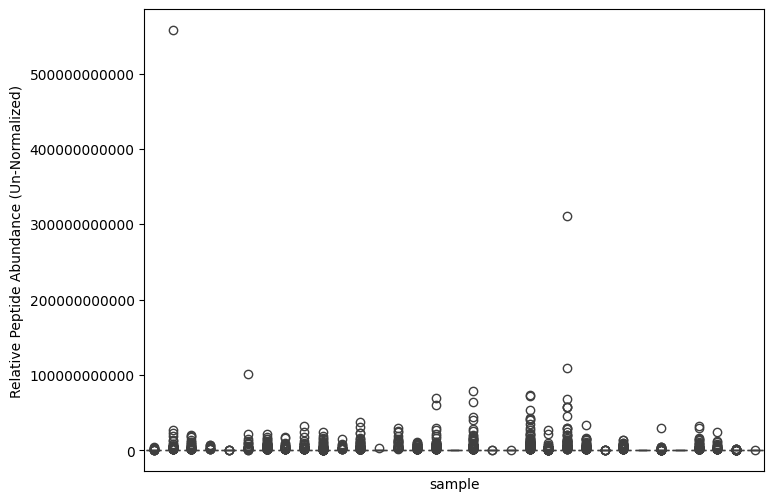

In [21]:
#plot untransformed abundance values
untransformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsArea',data=forward_peptides)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([])
plt.xlabel('sample')
plt.ylabel('Relative Peptide Abundance (Un-Normalized)')

Apply log2 transformation and median normalize peptide abundances.

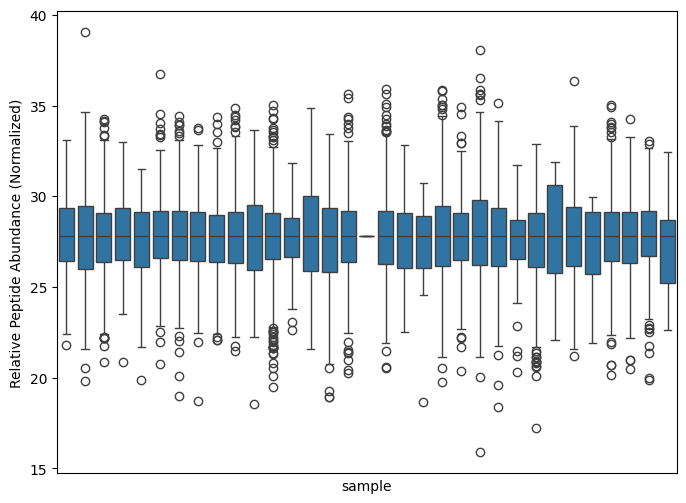

In [22]:
#log2 tranformation
forward_peptides['StatMomentsAreaLog2']=np.log2(forward_peptides['StatMomentsArea'])

# Calculate group-wise (sample wise) median
group_medians = forward_peptides.groupby('processed_DO_id')['StatMomentsAreaLog2'].median()

# Calculate data wide median
all_data_median=forward_peptides['StatMomentsAreaLog2'].median()

# Subtract sample wise median from each value within its group
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides.apply(
    lambda row: row['StatMomentsAreaLog2'] - group_medians[row['processed_DO_id']], axis=1
)

#add back in a data wide median value to avoid negative abundances
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides['StatMomentsAreaLog+Norm'] + all_data_median

transformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsAreaLog+Norm',data=forward_peptides)
plt.xticks([])
plt.xlabel('sample')
plt.ylabel('Relative Peptide Abundance (Normalized)')

del ax, group_medians, all_data_median, forward_peptides['StatMomentsArea'], forward_peptides['StatMomentsAreaLog2'], reversed_peptides

## 4) Extract functional gene annotations for proteins

Collect peptide to protein mapping information for the passing peptide sequences.

In [23]:
peptide_protein_mapping = pd.DataFrame(unfilt_res[unfilt_res['Peptide Sequence with Mods'].isin(forward_peptides['Peptide Sequence with Mods'])][['Peptide Sequence with Mods','Protein']].drop_duplicates()).reset_index(drop=True)
peptide_protein_mapping

,Peptide Sequence with Mods,Protein
0,NLTTGPGSAQEAIFNR,nmdc:wfmgan-11-z0q72297.1_004752_2_691
1,TYTLRPGAVAEFEER,nmdc:wfmgan-11-z0q72297.1_013275_1_561
2,ELASSAAYTTIQTVK,nmdc:wfmgan-11-z0q72297.1_056571_1_339
...,...,...
20302,AHLDQIVTR,nmdc:wfmgan-11-z0raab34.1_002480_199_1413
20303,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_005022_699_1082
20304,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_024291_3_491


Annotation information for these proteins can be found in 'Functional Annotation GFF' files.

Since the `data_objects` dataframe contains all objects associated with our study id, it also contains the relevant 'Functional Annotation GFF' files. Subset this dataframe to GFF files associated with the 33 biosample ids that have a proteomic output in `proteomic_output_df`.

In [24]:
annotation_input_df = data_objects[(data_objects['data_object_type']=='Functional Annotation GFF') & (data_objects['biosample_id'].isin(proteomic_output_df['biosample_id'].unique().tolist()))].reset_index(drop=True)
annotation_input_df = annotation_input_df[['id','file_size_bytes','data_object_type','md5_checksum','url','biosample_id']]
display(annotation_input_df)

,id,file_size_bytes,data_object_type,md5_checksum,url,biosample_id
0,nmdc:dobj-11-cncace51,41027989.0,Functional Annotation GFF,d4f6008ecb2a990fdd533365d16f547b,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-kcdh3w94
1,nmdc:dobj-11-c24s6186,114196066.0,Functional Annotation GFF,3049a60a48baca9133461a7cde827b6f,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-1p0tct86
2,nmdc:dobj-11-p55wx268,36135504.0,Functional Annotation GFF,56ca7bb11c7a299af52bfb23d2bfefa0,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-2fw5j754
...,...,...,...,...,...,...
30,nmdc:dobj-11-f6n2bs50,69287553.0,Functional Annotation GFF,4c2d463ad8a820bcbab591e6c398932e,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-3pvn5d70
31,nmdc:dobj-11-sr07nm98,66352443.0,Functional Annotation GFF,d29c8717338d7b1c47b07182cd576443,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-amdcp906
32,nmdc:dobj-11-2yvsr009,59167081.0,Functional Annotation GFF,41a3766ddaf4dc0b2f20a3ce0d69647c,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:bsm-13-vqk1y255


Preview the 'Functional Annotation GFF' files and determine a subset of gene annotation information that should be pulled from all 33 files.

In [25]:
#example annotation file
annotation_file=annotation_input_df.iloc[0]["url"]
print(annotation_file)
display(agg_func.gff_extract_features(annotation_file))

del annotation_file

https://data.microbiomedata.org/data/nmdc:omprc-13-z37b9193/nmdc:wfmgan-11-z0q72297.1/nmdc_wfmgan-11-z0q72297.1_functional_annotation.gff


,ID,translation_table,start_type,product,product_source,cath_funfam,cog,ko,pfam,superfamily,...,note,number_of_repeats,average_repeat_length,median_repeat_length,average_spacer_length,median_spacer_length,Parent,ncRNA_class,regulatory_class,bound_moiety
0,nmdc:wfmgan-11-z0q72297.1_000001_7_501,11,ATG,uncharacterized protein,KO:K09129,3.40.1520.10,COG1839,KO:K09129,PF04008,103165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nmdc:wfmgan-11-z0q72297.1_000001_822_2396,11,ATG,circadian clock protein KaiC,KO:K08482,3.40.50.300,COG0467,KO:K08482,PF06745,52540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nmdc:wfmgan-11-z0q72297.1_000001_2472_2807,11,ATG,hypothetical protein,Hypo-rule applied,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144459,nmdc:wfmgan-11-z0q72297.1_118419_2_199,11,ATG,carbamoyl-phosphate synthase large subunit,KO:K01955,3.30.470.20,COG0458,KO:K01955,PF02786,56059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144460,nmdc:wfmgan-11-z0q72297.1_118420_2_199,11,Edge,aryl-alcohol dehydrogenase-like predicted oxid...,COG0667,3.20.20.100,COG0667,NaN,PF00248,51430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144461,nmdc:wfmgan-11-z0q72297.1_118421_73_201,11,Edge,hypothetical protein,Hypo-rule applied,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract information from all 33 annotation files (this takes a while to run) and merge with `razormapping` so there is a final table of peptide-protein-annotation mapping (`annotation_mapping`).

In [26]:
#get gene annotation information for proteins
genemapping = annotation_input_df[["id", "url"]].drop_duplicates().reset_index(drop=True)

genemapping = agg_func.iterate_file_extract(
    pd_df=genemapping,\
    identifier_col='id',\
    url_col='url',\
    extract_cols=['ID','product','product_source'],\
    filter_col = 'ID',
    filter_values = peptide_protein_mapping['Protein'].unique().tolist(),
    file_type='gff'
)

#merge with protein mapping information. drop columns ID (which is equivalent to Protein) and id_col (which is the dataset id, unnecessary here since peptide to protein information isn't dataset specific)
annotation_mapping = genemapping.merge(peptide_protein_mapping,left_on='ID',right_on='Protein').drop(['ID','id_col'],axis=1)

annotation_mapping

KeyboardInterrupt: 

## 5) Generate annotation and protein mappings for peptides using "Razor" strategy

Identify the razor protein, which is a method of limiting the assignment of degenerate peptides (i.e., peptides that map to more than one forward protein) to a most likely matched protein. 'Razor' references the principle Occam's razor, also known as the law of parsimony.

The rules are as follows:
- If a peptide is unique to a protein, then that protein is the razor
- Else, if a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the razor
- Else, if a peptide belongs to more than one protein and one of those proteins has the maximal number of peptides, then that protein is the razor
- Else, if a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then collapse the proteins and gene annotations into single strings
- Else, if a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

Use `annotation_mapping` as the input to the function razorprotein() from the agg_func script. This will return protein and gene annotation information for each peptide, according to the above rules. 

In [19]:
razormapping = agg_func.razorprotein(annotation_mapping)
razormapping

,product,product_source,Peptide Sequence with Mods,razor
0,dodecin,KO:K09165,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,dodecin,KO:K09165,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,"dodecin, dodecin, dodecin, dodecin, dodecin","KO:K09165, KO:K09165, KO:K09165, KO:K09165, KO...",AAAAAVETASR,"nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...,...,...
5990,peptide/nickel transport system substrate-bind...,KO:K02035,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YgiT-type zinc finger domain-containing protei...,"TIGR03831, Hypo-rule applied",YYSADTLK,"nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
5992,uncharacterized protein,KO:K06996,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


## 6) Perform protein rollup and summarize into a final aggregated table of relative protein abundance

Combine razor information with relative abundance values.

In [20]:
#merge needs to be 'right' because some peptides are removed in mapping functions if they have indeterminante mappings
forward_peptides = forward_peptides.merge(razormapping,how='right',on=['Peptide Sequence with Mods'])
del annotation_mapping, peptide_protein_mapping, genemapping

forward_peptides

,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm,product,product_source,razor
0,nmdc:dobj-11-jqrf1211,AAAAAIATASR,30.072024,dodecin,KO:K09165,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,nmdc:dobj-11-vjmd5h28,AAAAAIETASR,30.886385,dodecin,KO:K09165,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,nmdc:dobj-11-tk9hc081,AAAAAVETASR,29.445066,"dodecin, dodecin, dodecin, dodecin, dodecin","KO:K09165, KO:K09165, KO:K09165, KO:K09165, KO...","nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...,...,...,...,...
10574,nmdc:dobj-11-jqrf1211,YYQDHFGQYGKGDVAGAQK,28.418944,peptide/nickel transport system substrate-bind...,KO:K02035,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
10575,nmdc:dobj-11-sx7cyr58,YYSADTLK,29.639770,YgiT-type zinc finger domain-containing protei...,"TIGR03831, Hypo-rule applied","nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
10576,nmdc:dobj-11-7psagy79,YYSELFGWQVHEVMPTYGLVHTEAGGK,27.099416,uncharacterized protein,KO:K06996,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


De-log the peptide abundances, sum the abundances for each razor protein and log transform the rolled up protein abundances.

In [21]:
#de-log abundance
forward_peptides['StatMomentsAreaNorm']=2**forward_peptides['StatMomentsAreaLog+Norm']
forward_peptides.drop('StatMomentsAreaLog+Norm',axis=1,inplace=True)

#sum abundance for each sorted_list protein in each dataset
prot_info = forward_peptides.columns[~forward_peptides.columns.isin(['StatMomentsAreaNorm','Peptide Sequence with Mods'])].tolist()
protein_abundances = forward_peptides.groupby(prot_info)['StatMomentsAreaNorm'].sum().reset_index()

#re-log2 tranform abundance
protein_abundances['StatMomentsAreaLog+Norm']=np.log2(protein_abundances['StatMomentsAreaNorm'])
protein_abundances.drop('StatMomentsAreaNorm',axis=1,inplace=True)

del prot_info, forward_peptides

protein_abundances

,processed_DO_id,product,product_source,razor,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,"DNA-binding protein HU-beta, DNA-binding prote...","KO:K03530, KO:K03530","nmdc:wfmgan-11-8zxjs882.1_040719_104_331, nmdc...",25.331800
1,nmdc:dobj-11-2k6s1505,DNA-binding transcriptional LysR family regula...,"COG0583, COG0583, COG0583, COG0583, COG0583","nmdc:wfmgan-11-21ms6426.1_010178_1_894, nmdc:w...",26.476612
2,nmdc:dobj-11-2k6s1505,DNA-directed RNA polymerase subunit beta',KO:K03046,nmdc:wfmgan-11-yjeh0m30.1_003176_3_1979,27.186508
...,...,...,...,...,...
8090,nmdc:dobj-11-zn9eyg46,peptidoglycan/xylan/chitin deacetylase (PgdA/C...,"COG0726, COG0726, COG0726","nmdc:wfmgan-11-6pq4bd13.1_001294_1_411, nmdc:w...",25.205457
8091,nmdc:dobj-11-zn9eyg46,"photosystem II CP43 chlorophyll apoprotein, ph...","KO:K02705, KO:K02705, KO:K02705","nmdc:wfmgan-11-hyze3t58.1_07201_3_464, nmdc:wf...",28.680965
8092,nmdc:dobj-11-zn9eyg46,predicted porin,COG3203,nmdc:wfmgan-11-hyze3t58.1_02099_286_783,29.223505


## Final aggregated table of relative protein abundance

Reformat these results into a proteomic table, where each row indicates a protein and each column indicates a sample/dataset. The values within are log transformed, median normalized relative abundance values. This table or the longform version above can be used in further proteomic analyses.

In [22]:
#pivot to wide crosstab
aggregated_proteomic_output = protein_abundances.pivot(index='razor',columns='processed_DO_id',values='StatMomentsAreaLog+Norm')
aggregated_proteomic_output.columns.name = None

aggregated_proteomic_output

,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2szyc560,nmdc:dobj-11-301yh759,nmdc:dobj-11-3378mg86,nmdc:dobj-11-3ak2bc31,nmdc:dobj-11-4bwzhs42,nmdc:dobj-11-7psagy79,nmdc:dobj-11-7r5yea49,nmdc:dobj-11-7x21d450,nmdc:dobj-11-bxyvx506,...,nmdc:dobj-11-vjmd5h28,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-x6srbx72,nmdc:dobj-11-xm1yjv87,nmdc:dobj-11-y2aefn18,nmdc:dobj-11-yrbs4v96,nmdc:dobj-11-z47wnf07,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-zhz66007,nmdc:dobj-11-zn9eyg46
razor,,,,,,,,,,,,,,,,,,,,,
nmdc:wfmgan-11-21ms6426.1_000036_702_1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"nmdc:wfmgan-11-21ms6426.1_000053_3_563, nmdc:wfmgan-11-p3dkkz54.1_008013_251_1072",NaN,NaN,NaN,NaN,NaN,NaN,30.583253,NaN,NaN,NaN,...,33.014350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"nmdc:wfmgan-11-21ms6426.1_000057_4146_5369, nmdc:wfmgan-11-p3dkkz54.1_002120_389_1612, nmdc:wfmgan-11-z0raab34.1_009908_3_737",NaN,30.151457,28.487414,29.017211,NaN,NaN,30.541714,NaN,NaN,28.802433,...,30.533987,26.55462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nmdc:wfmgan-11-z0raab34.1_148395_2_283,NaN,31.457246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_160266_3_278,NaN,27.833779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_167280_3_278,NaN,24.800805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The generated protein table can be used as input to the software [pmartR](https://shinyproxy.emsl.pnnl.gov/app/pmart), which performs statistical analyses such as ANOVA and independence of missing data (IMD) tests. In this case, the aggregated proteomics table (`aggregated_proteomic_output`) would be equivalent to pmartR's `e_data` and the peptide to protein to gene mappings (`razor_mapping`) would be equivalent to pmartR's `e_meta`.

<img src="../pmartR_logo_final.jpg" width="25%"/>


pmartR requires sample metadata to parameterize analyses and interpret the data. For this example dataset, an API call will capture the biosample metadata (`sample_metadata`) that would be equivalent to pmartR's `f_data`.

Gather biosample metadata via the nmdc_api_utilites `BiosampleSeach` object, using the function get_record_by_filter() in `biosample_id`s associated with each output in `proteomic_output_df`.

In [29]:
from nmdc_api_utilities.biosample_search import BiosampleSearch
# since we are querying the biosample collection, we need to create an instance of it
bs_client = BiosampleSearch()

# use utility function to get a list of the ids from processed_nom
result_ids = get_id_list(proteomic_output_df.to_dict(orient='records'), "biosample_id")
# create a list of lists of ids to query the BiosampleSearch object
chunked_list = split_list(result_ids)
biosamples = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the BiosampleSearch object looking for records where the id field is in the chunk of ids from proteomic_output_df
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    biosamples += bs_client.get_record_by_filter(filter=filter,fields="id,depth.has_numeric_value", max_page_size=100, all_pages=True)

#normalize the json columns
biosamples = pd.json_normalize(biosamples).drop_duplicates().rename(columns={'id':'biosample_id'})

#merge biosample and processed data object information
sample_metadata = biosamples.merge(proteomic_output_df[['processed_DO_id','biosample_id']],on='biosample_id')
del biosamples

sample_metadata

,biosample_id,depth.has_numeric_value,processed_DO_id
0,nmdc:bsm-13-0jw5n594,0.0,nmdc:dobj-11-pxnhdj84
1,nmdc:bsm-13-13145k83,0.2,nmdc:dobj-11-xm1yjv87
2,nmdc:bsm-13-1p0tct86,0.2,nmdc:dobj-11-bxyvx506
...,...,...,...
30,nmdc:bsm-13-xvf06c81,0.4,nmdc:dobj-11-m808mj05
31,nmdc:bsm-13-yjp2dx65,0.1,nmdc:dobj-11-301yh759
32,nmdc:bsm-13-zms1jq91,0.5,nmdc:dobj-11-sx7cyr58
